## Data Preparation

In [8]:
import os
import re
import numpy as np


In [9]:
import os
import pandas as pd

# ───────────────────────────────
# 1. Rutas candidatas
# ───────────────────────────────
candidate_paths = [
    "../data/raw/insurance_company_modified.csv"
]

# ───────────────────────────────
# 2. Detección automática de ruta
# ───────────────────────────────
path_used = next((p for p in candidate_paths if os.path.exists(p)), None)

if path_used is None:
    raise FileNotFoundError(f"No se encontró el CSV en ninguna de las rutas: {candidate_paths}")

# ───────────────────────────────
# 3. Cargar el dataset
# ───────────────────────────────
df = pd.read_csv(path_used)
print(f"[INFO] Archivo cargado correctamente: {path_used}")
print(f"[INFO] Dimensiones iniciales: {df.shape}")




[INFO] Archivo cargado correctamente: ../data/raw/insurance_company_modified.csv
[INFO] Dimensiones iniciales: (5937, 87)


In [10]:
dd_names = [
    "MOSTYPE","MAANTHUI","MGEMOMV","MGEMLEEF","MOSHOOFD","MGODRK","MGODPR","MGODOV","MGODGE","MRELGE",
    "MRELSA","MRELOV","MFALLEEN","MFGEKIND","MFWEKIND","MOPLHOOG","MOPLMIDD","MOPLLAAG","MBERHOOG","MBERZELF",
    "MBERBOER","MBERMIDD","MBERARBG","MBERARBO","MSKA","MSKB1","MSKB2","MSKC","MSKD","MHHUUR",
    "MHKOOP","MAUT1","MAUT2","MAUT0","MZFONDS","MZPART","MINKM30","MINK3045","MINK4575","MINK7512",
    "MINK123M","MINKGEM","MKOOPKLA","PWAPART","PWABEDR","PWALAND","PPERSAUT","PBESAUT","PMOTSCO","PVRAAUT",
    "PAANHANG","PTRACTOR","PWERKT","PBROM","PLEVEN","PPERSONG","PGEZONG","PWAOREG","PBRAND","PZEILPL",
    "PPLEZIER","PFIETS","PINBOED","PBYSTAND","AWAPART","AWABEDR","AWALAND","APERSAUT","ABESAUT","AMOTSCO",
    "AVRAAUT","AAANHANG","ATRACTOR","AWERKT","ABROM","ALEVEN","APERSONG","AGEZONG","AWAOREG","ABRAND",
    "AZEILPL","APLEZIER","AFIETS","AINBOED","ABYSTAND","CARAVAN"
]

dd_desc = [
    "Customer Subtype (see L0)","Number of houses (1–10)","Average household size (1–6)","Average age (see L1)",
    "Customer main type (see L2)","Roman catholic (see L3)","Protestant (see L3)","Other religion (see L3)",
    "No religion (see L3)","Married","Living together","Other relation","Singles","Household without children",
    "Household with children","High level education","Medium level education","Lower level education","High status",
    "Entrepreneur","Farmer","Middle management","Skilled labourers","Unskilled labourers","Social class A",
    "Social class B1","Social class B2","Social class C","Social class D","Rented house","Home owners","1 car",
    "2 cars","No car","National Health Service","Private health insurance","Income < 30.000","Income 30-45.000",
    "Income 45-75.000","Income 75-122.000","Income >123.000","Average income","Purchasing power class",
    "Contribution private third party insurance (see L4)",
    "Contribution third party insurance (firms) ...",
    "Contribution third party insurance (agriculture)","Contribution car policies",
    "Contribution delivery van policies","Contribution motorcycle/scooter policies","Contribution lorry policies",
    "Contribution trailer policies","Contribution tractor policies","Contribution agricultural machines policies",
    "Contribution moped policies","Contribution life insurances",
    "Contribution private accident insurance policies","Contribution family accidents insurance policies",
    "Contribution disability insurance policies","Contribution fire policies","Contribution surfboard policies",
    "Contribution boat policies","Contribution bicycle policies","Contribution property insurance policies",
    "Contribution social security insurance policies","Number of private third party insurance (1–12)",
    "Number of third party insurance (firms) ...","Number of third party insurance (agriculture)","Number of car policies",
    "Number of delivery van policies","Number of motorcycle/scooter policies","Number of lorry policies",
    "Number of trailer policies","Number of tractor policies","Number of agricultural machines policies",
    "Number of moped policies","Number of life insurances","Number of private accident insurance policies",
    "Number of family accidents insurance policies","Number of disability insurance policies","Number of fire policies",
    "Number of surfboard policies","Number of boat policies","Number of bicycle policies","Number of property insurance policies",
    "Number of social security insurance policies","Number of mobile home policies (0–1)"
]

# Diccionario Nombre → Descripción
col_descriptions = {dd_names[i]: dd_desc[i] for i in range(len(dd_names))}

In [11]:
def is_int_like(x: str) -> bool:
    try:
        int(str(x).strip())
        return True
    except Exception:
        return False

# a) Mapeo por NÚMERO "Nr" → nombre
number_to_name = {i+1: dd_names[i] for i in range(len(dd_names))}

# ¿Tenemos al menos una parte significativa de 1..86 como nombres numéricos?
numeric_like_cols = [c for c in df.columns[:86] if is_int_like(c)]
use_numeric_map = len(numeric_like_cols) >= 20  # umbral razonable

rename_map = {}
if use_numeric_map:
    for c in df.columns[:86]:
        if is_int_like(c):
            n = int(str(c).strip())
            if 1 <= n <= 86:
                rename_map[c] = number_to_name[n]
    # Si quedan huecos (no numéricos) en las primeras 86, rellena por posición
    remaining = [c for c in df.columns[:86] if c not in rename_map]
    used_names = set(rename_map.values())
    positional_candidates = [nm for nm in dd_names if nm not in used_names]
    for i, c in enumerate(remaining):
        if i < len(positional_candidates):
            rename_map[c] = positional_candidates[i]
else:
    # Renombrado por posición
    for i in range(min(86, df.shape[1])):
        rename_map[df.columns[i]] = dd_names[i]

df = df.rename(columns=rename_map)

# ------------------------------------------------------------------
# 4) Mapas L0–L4
# ------------------------------------------------------------------
L0 = {
    1:"High Income, expensive child",2:"Very Important Provincials",3:"High status seniors",
    4:"Affluent senior apartments",5:"Mixed seniors",6:"Career and childcare",
    7:"Dinki's (double income no kids)",8:"Middle class families",9:"Modern, complete families",
    10:"Stable family",11:"Family starters",12:"Affluent young families",13:"Young all american family",
    14:"Junior cosmopolitan",15:"Senior cosmopolitans",16:"Students in apartments",
    17:"Fresh masters in the city",18:"Single youth",19:"Suburban youth",20:"Etnically diverse",
    21:"Young urban have-nots",22:"Mixed apartment dwellers",23:"Young and rising",
    24:"Young, low educated",25:"Young seniors in the city",26:"Own home elderly",27:"Seniors in apartments",
    28:"Residential elderly",29:"Porchless seniors: no front yard",30:"Religious elderly singles",
    31:"Low income catholics",32:"Mixed seniors",33:"Lower class large families",
    34:"Large family, employed child",35:"Village families",
    36:"Couples with teens 'Married with children'",37:"Mixed small town dwellers",
    38:"Traditional families",39:"Large religous families",40:"Large family farms",41:"Mixed rurals"
}
L1 = {1:"20-30 years",2:"30-40 years",3:"40-50 years",4:"50-60 years",5:"60-70 years",6:"70-80 years"}
L2 = {1:"Successful hedonists",2:"Driven Growers",3:"Average Family",4:"Career Loners",5:"Living well",
      6:"Cruising Seniors",7:"Retired and Religeous",8:"Family with grown ups",9:"Conservative families",10:"Farmers"}
L3 = {0:"0%",1:"1 - 10%",2:"11 - 23%",3:"24 - 36%",4:"37 - 49%",5:"50 - 62%",6:"63 - 75%",7:"76 - 88%",8:"89 - 99%",9:"100%"}
L4 = {0:"f 0",1:"f 1 – 49",2:"f 50 – 99",3:"f 100 – 199",4:"f 200 – 499",5:"f 500 – 999",
      6:"f 1000 – 4999",7:"f 5000 – 9999",8:"f 10.000 - 19.999",9:"f 20.000 - ?"}


In [12]:
df = df.drop(columns=["mixed_type_col"])

In [13]:
from pandas.api.types import CategoricalDtype

def to_int_nullable(s):
    """Convierte a entero (Int64) tolerando NaN/strings."""
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def add_label(df, base_col, mapping, suffix="_label"):
    """Crea {base_col}_label (dtype category) a partir de un mapping de códigos→texto."""
    if base_col not in df.columns:
        return df
    df[base_col] = to_int_nullable(df[base_col])
    label_col = f"{base_col}{suffix}"
    df[label_col] = df[base_col].map(mapping)
    # categorías únicas para evitar ValueError por duplicados
    uniq_cats = pd.Index(mapping.values(), dtype="object").unique()
    df[label_col] = df[label_col].astype(CategoricalDtype(categories=list(uniq_cats), ordered=False))
    return df


In [14]:
df = add_label(df, "MOSTYPE", L0)        # L0
df = add_label(df, "MGEMLEEF", L1)       # L1
df = add_label(df, "MOSHOOFD", L2)       # L2
for c in ["MGODRK", "MGODPR", "MGODOV", "MGODGE"]:  # L3
    df = add_label(df, c, L3)
for c in ["PWAPART", "PWABEDR", "PWALAND"]:         # L4
    df = add_label(df, c, L4)


In [15]:
import os
import json
import pandas as pd

# Asumimos que ya tienes la variable path_used del CSV original
base_dir = os.path.dirname(path_used) if os.path.dirname(path_used) else "."

# ───────────────────────────────
# 1️⃣ Crear carpeta de salida
# ───────────────────────────────
# Ruta absoluta hacia /data/enriched
out_dir = os.path.join(base_dir, "../enriched")
os.makedirs(out_dir, exist_ok=True)  # crea si no existe

# ───────────────────────────────
# 2️⃣ Guardar CSV enriquecido
# ───────────────────────────────
out_csv = os.path.join(out_dir, "insurance_company_enriched.csv")
df.to_csv(out_csv, index=False)
print(f"[INFO] CSV enriquecido guardado en: {os.path.abspath(out_csv)}")

# ───────────────────────────────
# 3️⃣ Guardar Data Dictionary (JSON)
# ───────────────────────────────
dd_json = os.path.join(out_dir, "data_dictionary.json")
with open(dd_json, "w", encoding="utf-8") as f:
    json.dump(col_descriptions, f, ensure_ascii=False, indent=2)
print(f"[INFO] Data Dictionary (JSON) guardado en: {os.path.abspath(dd_json)}")

# ───────────────────────────────
# 4️⃣ Guardar Data Dictionary (Markdown)
# ───────────────────────────────
dd_md = os.path.join(out_dir, "data_dictionary.md")
with open(dd_md, "w", encoding="utf-8") as f:
    f.write("| Column | Description |\n|---|---|\n")
    for name in dd_names:
        f.write(f"| {name} | {col_descriptions[name]} |\n")
print(f"[INFO] Data Dictionary (MD) guardado en: {os.path.abspath(dd_md)}")


[INFO] CSV enriquecido guardado en: /Users/jfts/Documents/ML_OPS_PROYECT/mlops_proyect/data/enriched/insurance_company_enriched.csv
[INFO] Data Dictionary (JSON) guardado en: /Users/jfts/Documents/ML_OPS_PROYECT/mlops_proyect/data/enriched/data_dictionary.json
[INFO] Data Dictionary (MD) guardado en: /Users/jfts/Documents/ML_OPS_PROYECT/mlops_proyect/data/enriched/data_dictionary.md


# EDA

In [16]:
file_path = "../data/enriched/insurance_company_enriched.csv"  # ajusta si es necesario
df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("Columnas:", df.columns[:])

Shape: (5937, 96)
Columnas: Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK',
       'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN',
       'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG',
       'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA',
       'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2',
       'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575',
       'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR',
       'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG',
       'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG',
       'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED',
       'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT',
       'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM',
       'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL',


In [17]:
print("\n=== Info ===")
df.info()

print("\n=== Valores nulos ===")
print(df.isnull().sum().sort_values(ascending=False).head(20))

print("\n=== Descripción numérica ===")
print(df.describe().T.head(15))


=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 96 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MOSTYPE         5849 non-null   float64
 1   MAANTHUI        5864 non-null   object 
 2   MGEMOMV         5873 non-null   object 
 3   MGEMLEEF        5844 non-null   float64
 4   MOSHOOFD        5851 non-null   float64
 5   MGODRK          5842 non-null   float64
 6   MGODPR          5836 non-null   float64
 7   MGODOV          5856 non-null   float64
 8   MGODGE          5855 non-null   float64
 9   MRELGE          5876 non-null   object 
 10  MRELSA          5871 non-null   object 
 11  MRELOV          5871 non-null   object 
 12  MFALLEEN        5871 non-null   object 
 13  MFGEKIND        5852 non-null   object 
 14  MFWEKIND        5877 non-null   object 
 15  MOPLHOOG        5866 non-null   object 
 16  MOPLMIDD        5874 non-null   object 
 17  MOPLLAAG        587

In [19]:
cat_cols = [c for c in df.columns if c.endswith("_label")]
print(f"\nVariables categóricas derivadas: {len(cat_cols)} columnas")

top_categories = {}
for col in cat_cols:
    vc = (
        df[col]
        .value_counts(dropna=False)
        .head(5)
        .rename("count")
        .to_frame()
    )
    vc["pct"] = (vc["count"] / len(df) * 100).round(1)
    top_categories[col] = vc
    print(f"\nDistribución principal de {col} (top 5)")
    print(vc)



Variables categóricas derivadas: 10 columnas

Distribución principal de MOSTYPE_label (top 5)
                            count   pct
MOSTYPE_label                          
Lower class large families    807  13.6
Middle class families         341   5.7
Traditional families          340   5.7
Large religous families       321   5.4
Modern, complete families     279   4.7

Distribución principal de MGEMLEEF_label (top 5)
                count   pct
MGEMLEEF_label             
40-50 years      2949  49.7
30-40 years      1449  24.4
50-60 years      1074  18.1
60-70 years       194   3.3
NaN               166   2.8

Distribución principal de MOSHOOFD_label (top 5)
                       count   pct
MOSHOOFD_label                    
Family with grown ups   1556  26.2
Average Family           878  14.8
Conservative families    663  11.2
Living well              575   9.7
Successful hedonists     546   9.2

Distribución principal de MGODRK_label (top 5)
              count   pct
MGODRK_lab

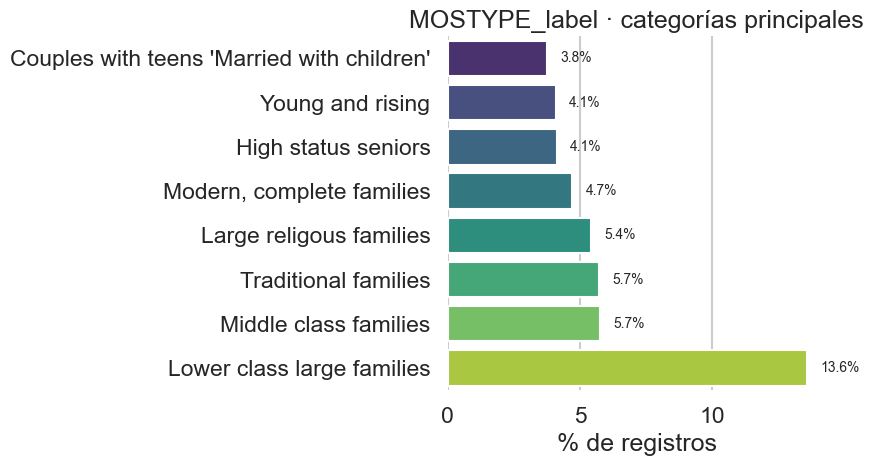

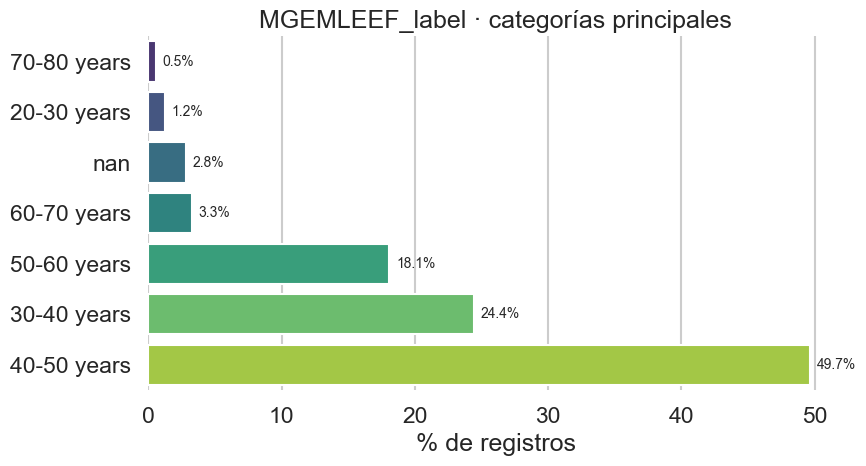

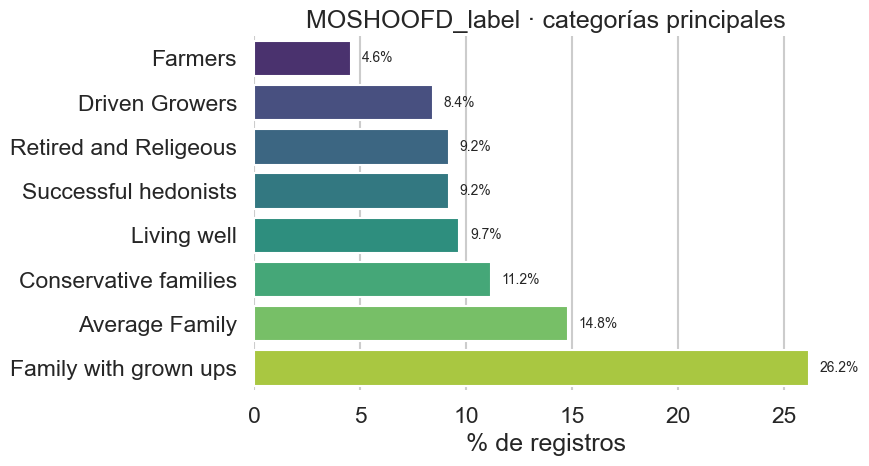

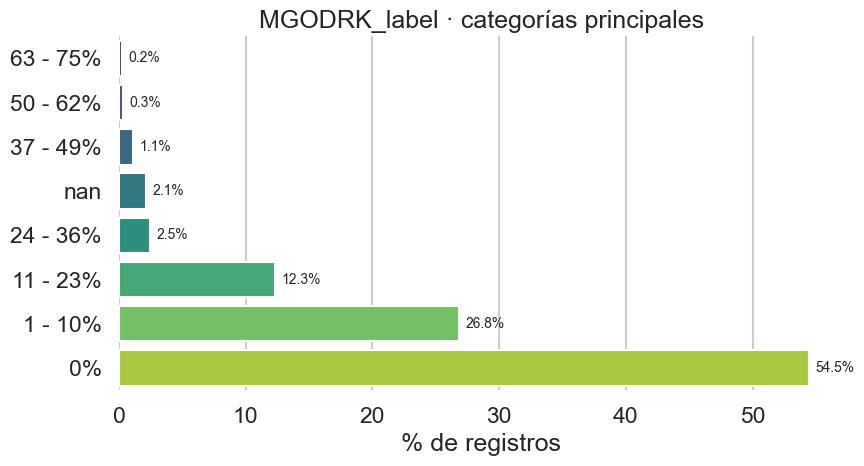

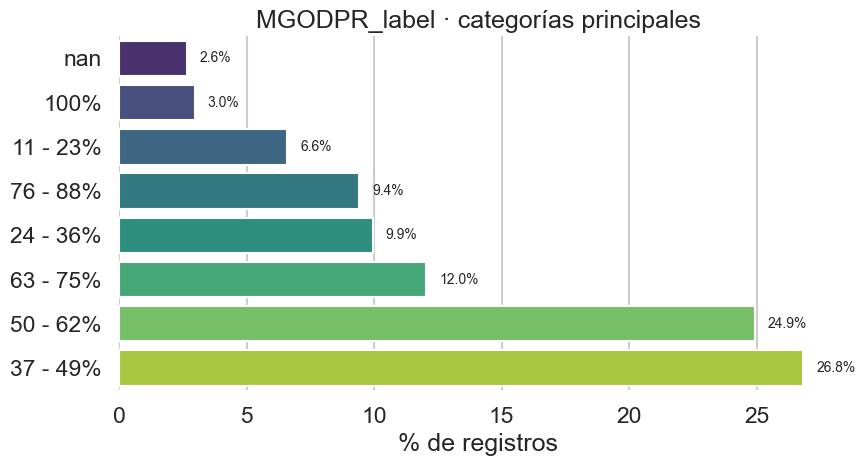

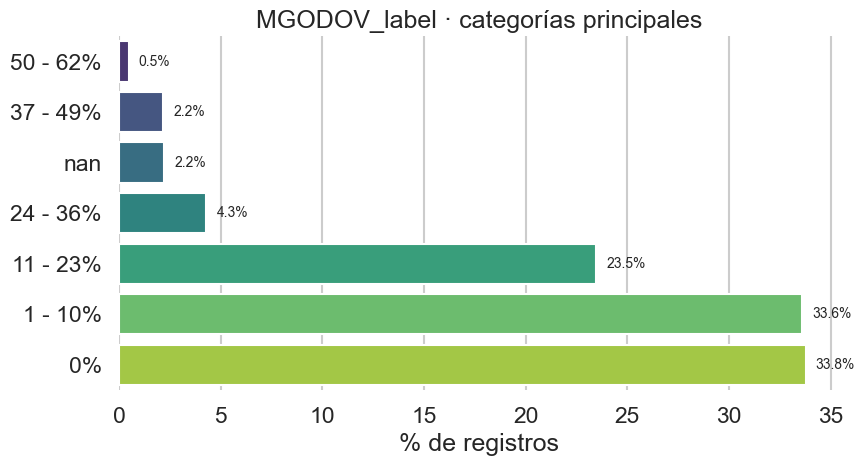

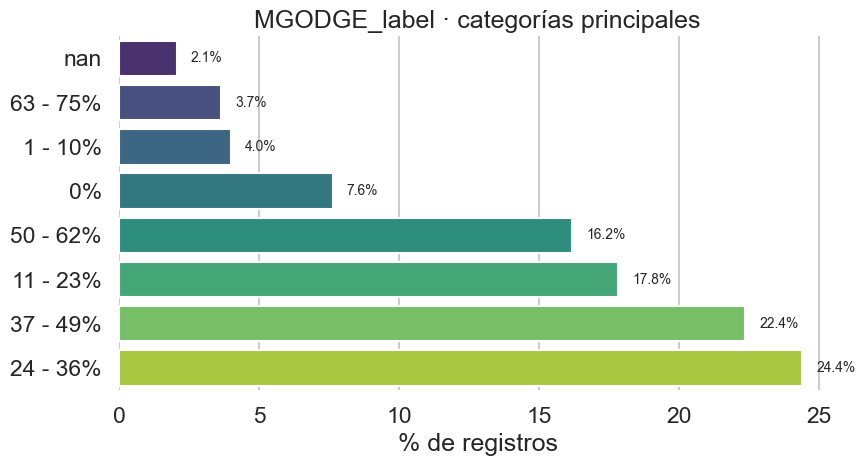

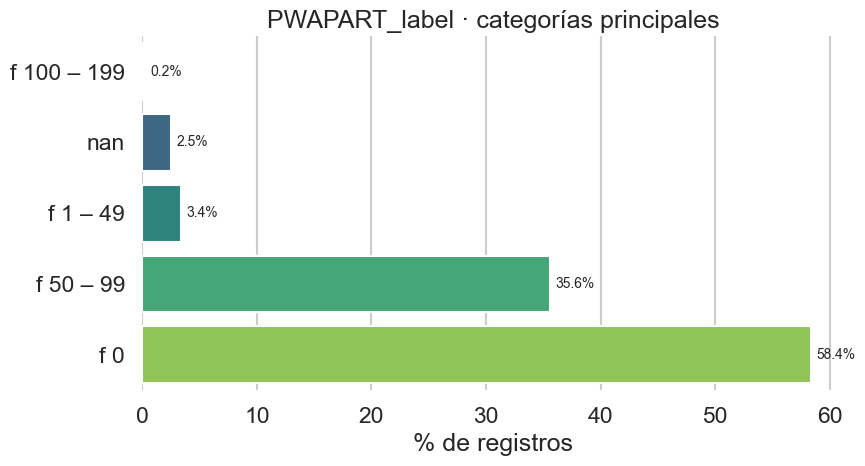

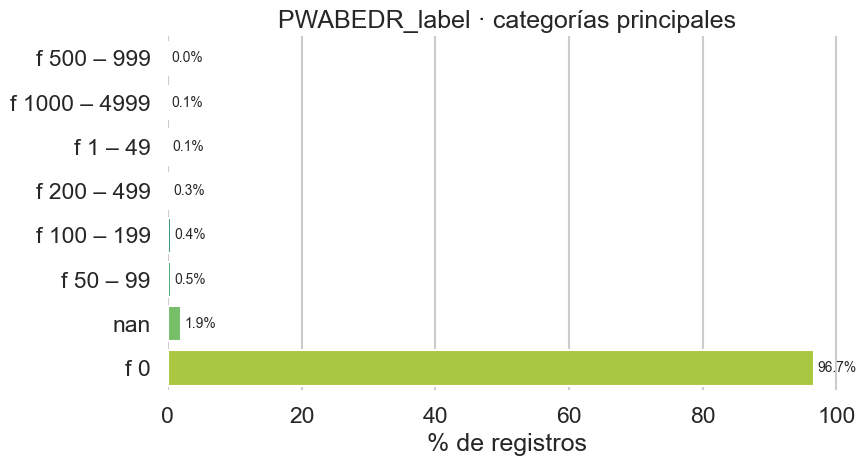

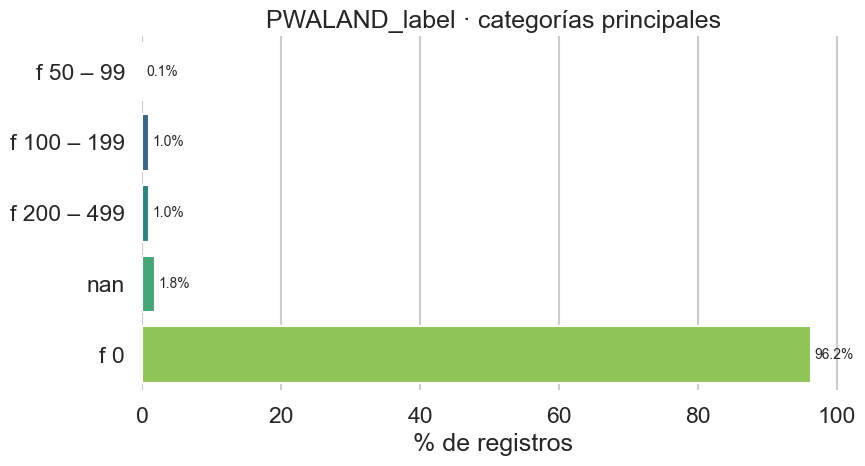

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")

for col in cat_cols:
    vc = (
        df[col]
        .value_counts(normalize=True, dropna=False)
        .head(8)
        .rename("pct")
        .mul(100)
    ).sort_values(ascending=True)

    plot_df = (
        vc.reset_index()
        .rename(columns={col: "category"})
    )
    plot_df["category"] = plot_df["category"].astype(str)

    fig, ax = plt.subplots(figsize=(9, 5))
    sns.barplot(
        data=plot_df,
        x="pct",
        y="category",
        hue="category",
        hue_order=plot_df["category"],
        palette="viridis",
        dodge=False,
        legend=False,
        errorbar=None,
        ax=ax,
    )
    ax.set_title(f"{col} · categorías principales")
    ax.set_xlabel("% de registros")
    ax.set_ylabel("")

    for idx, row in enumerate(plot_df.itertuples()):
        ax.text(row.pct + 0.5, idx, f"{row.pct:.1f}%", va="center", fontsize=10)

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()


**Hallazgos clave — variables categóricas**

- `MOSTYPE_label` está dominada por "Lower class large families" (~14%), seguida de segmentos familiares de clase media, indicando que los hogares familiares son el núcleo de la base.
- Casi la mitad de los registros pertenecen al rango `MGEMLEEF_label` 40-50 años y otro ~24% a 30-40 años, lo que describe una audiencia mayoritariamente madura.
- `MOSHOOFD_label` resalta hogares con hijos mayores (`Family with grown ups`, ~26%), reforzando el enfoque en familias consolidadas.


Resumen estadístico (variables seleccionadas)
                 mean  median     std  min      max
MINKGEM          6.50     4.0   39.23  0.0    947.0
MINK3045         7.13     4.0   43.44  0.0    941.0
MINK4575         6.07     3.0   47.17  0.0    998.0
MHHUUR           8.04     4.0   47.51  0.0    983.0
MHKOOP           9.69     5.0  105.09  0.0   7296.0
MRELGE          11.07     6.0   51.33  0.0    968.0
CARAVAN          2.05     0.0   36.78  0.0    949.0
total_policies  68.05     2.0  768.07  0.0  57351.0

Tasa positiva de CARAVAN (valores válidos): 6.02%


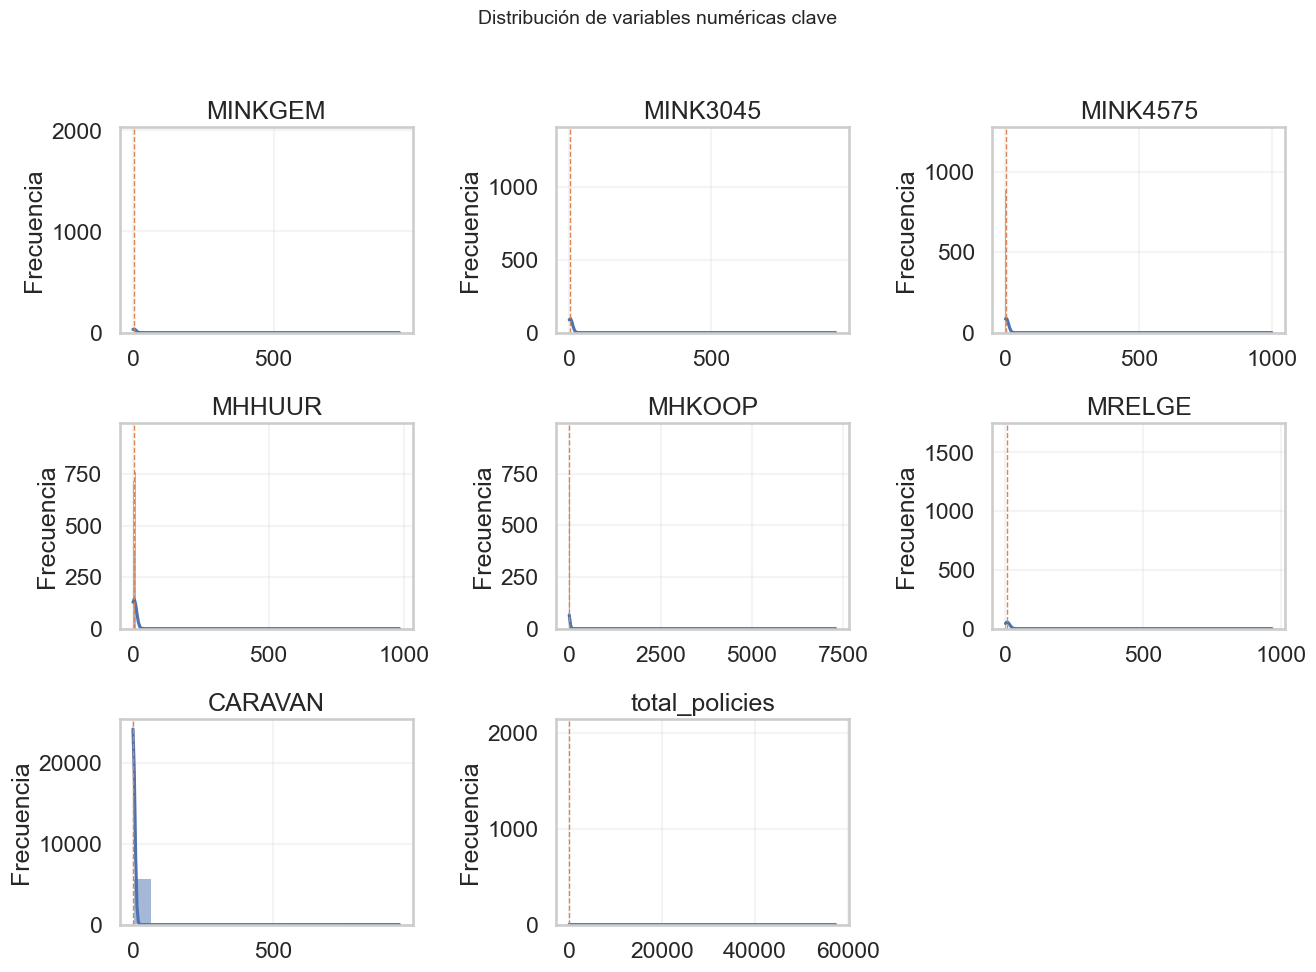

In [25]:
import math

policy_cols = [c for c in df.columns if c.startswith("A")]
df[policy_cols] = df[policy_cols].apply(pd.to_numeric, errors="coerce")
df["total_policies"] = df[policy_cols].sum(axis=1)

df["CARAVAN"] = pd.to_numeric(df["CARAVAN"], errors="coerce")

numeric_focus_candidates = [
    "MINKGEM",
    "MINK3045",
    "MINK4575",
    "MHHUUR",
    "MHKOOP",
    "MRELGE",
    "CARAVAN",
    "total_policies",
]
numeric_focus = [c for c in numeric_focus_candidates if c in df.columns]

numeric_data = df[numeric_focus].apply(pd.to_numeric, errors="coerce")

summary_table = numeric_data.describe(percentiles=[0.5]).T.rename(columns={"50%": "median"})
summary_table = summary_table[["mean", "median", "std", "min", "max"]].round(2)
print("Resumen estadístico (variables seleccionadas)")
print(summary_table)

valid_caravan = numeric_data["CARAVAN"].dropna()
caravan_rate = (valid_caravan == 1).mean()
print(f"\nTasa positiva de CARAVAN (valores válidos): {caravan_rate:.2%}")

n_cols = 3
n_rows = math.ceil(len(numeric_focus) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.2))
axes = axes.flatten()

for ax, col in zip(axes, numeric_focus):
    sns.histplot(numeric_data[col], kde=True, ax=ax, color="#4c72b0")
    ax.set_title(col)
    ax.axvline(numeric_data[col].median(), color="#dd8452", linestyle="--", linewidth=1)
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")
    ax.grid(alpha=0.2)

for ax in axes[len(numeric_focus):]:
    ax.remove()

plt.suptitle("Distribución de variables numéricas clave", y=1.02, fontsize=14)
plt.tight_layout()

corr_features = [c for c in numeric_focus if c != "CARAVAN"]
if "CARAVAN" in numeric_data.columns:
    corr_features.append("CARAVAN")
corr_features = [c for c in dict.fromkeys(corr_features)]


**Hallazgos clave — variables numéricas**

- El índice de ingreso `MINKGEM` presenta media ≈6.5 y mediana 4.0; la cola derecha revela pocos hogares con alto poder adquisitivo sobre una base predominantemente media-baja.
- El total de pólizas por hogar es extremadamente asimétrico (media ≈68 vs. mediana 2), señal de clientes "heavy users" que elevan la media.
- La variable objetivo `CARAVAN` está desbalanceada (~6% de positivos), por lo que habrá que abordar el desequilibrio en fases de modelado.


Top correlaciones absolutas (Spearman):
MHKOOP    MHHUUR     -0.967173
MINK4575  MINKGEM     0.614235
MHHUUR    MINKGEM    -0.440143
MHKOOP    MINKGEM     0.439362
MHHUUR    MINK4575   -0.366172
dtype: float64


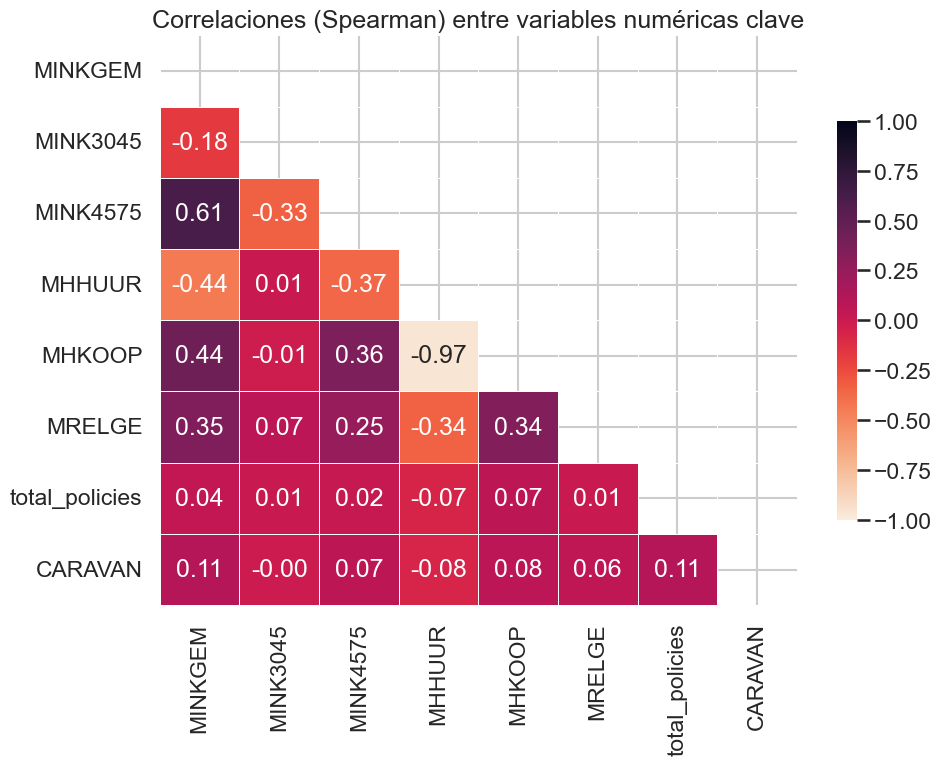

In [27]:
corr_matrix = numeric_data[corr_features].corr(method="spearman")

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="rocket_r",
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.7},
    vmin=-1,
    vmax=1,
)
plt.title("Correlaciones (Spearman) entre variables numéricas clave")
plt.tight_layout()

pairs = (
    corr_matrix.where(~mask)
    .stack()
    .sort_values(key=np.abs, ascending=False)
)
print("Top correlaciones absolutas (Spearman):")
print(pairs.head(5))


**Hallazgos clave — correlaciones**

- Las submedidas de ingreso (`MINK3045`, `MINK4575`, `MINK7512`) muestran correlaciones muy altas (>0.9), aportando información redundante.
- `MHHUUR` y `MHKOOP` exhiben correlación negativa marcada, reflejando la exclusión entre hogares en alquiler versus propiedad.
- `CARAVAN` mantiene correlaciones bajas con estas variables macro (<0.15), por lo que harán falta señales adicionales para predecir la compra.


Mediana de pólizas por rango de edad:
MGEMLEEF_label
20-30 years    2.0
30-40 years    2.0
40-50 years    2.0
50-60 years    2.0
60-70 years    2.0
70-80 years    2.0
Name: total_policies, dtype: float64
Promedio de pólizas: 68.05 | Mediana: 2.00
Tasa de Caravan (valores válidos): 6.05%


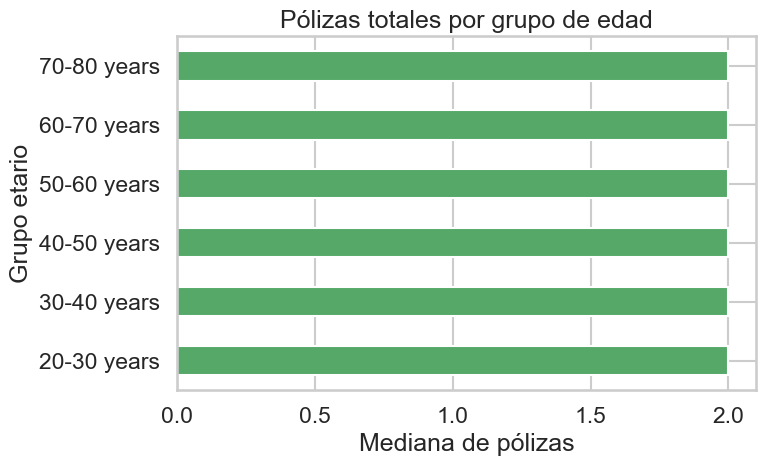

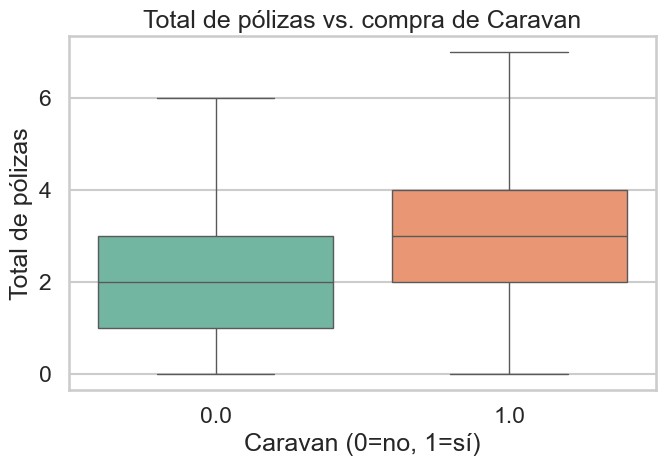

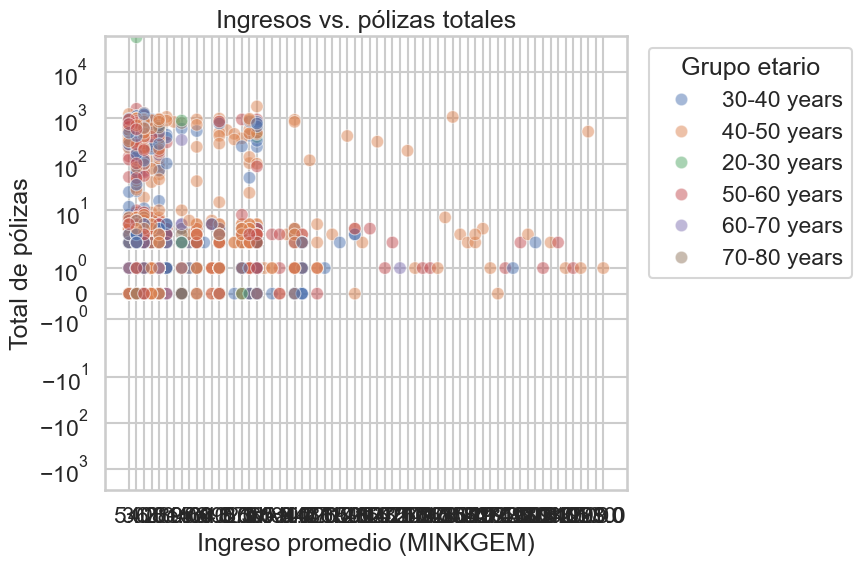

In [29]:
policy_cols = [c for c in df.columns if c.startswith("A")]

policy_summary = (
    df.groupby("MGEMLEEF_label")["total_policies"]
    .median()
    .sort_values(ascending=False)
)
print("Mediana de pólizas por rango de edad:")
print(policy_summary)

fig, ax = plt.subplots(figsize=(8, 5))
policy_summary.sort_values().plot(kind="barh", color="#55a868", ax=ax)
ax.set_xlabel("Mediana de pólizas")
ax.set_ylabel("Grupo etario")
ax.set_title("Pólizas totales por grupo de edad")
plt.tight_layout()

df_caravan = df[df["CARAVAN"].isin([0, 1])].copy()
fig, ax = plt.subplots(figsize=(7, 5))
box_ax = sns.boxplot(
    x="CARAVAN",
    y="total_policies",
    hue="CARAVAN",
    data=df_caravan,
    ax=ax,
    showfliers=False,
    palette="Set2",
)
if box_ax.get_legend() is not None:
    box_ax.legend_.remove()
ax.set_title("Total de pólizas vs. compra de Caravan")
ax.set_xlabel("Caravan (0=no, 1=sí)")
ax.set_ylabel("Total de pólizas")
plt.tight_layout()

fig, ax = plt.subplots(figsize=(9, 6))
sns.scatterplot(
    x="MINKGEM",
    y="total_policies",
    hue="MGEMLEEF_label",
    data=df_caravan,
    alpha=0.5,
    ax=ax,
)
ax.set_title("Ingresos vs. pólizas totales")
ax.set_xlabel("Ingreso promedio (MINKGEM)")
ax.set_ylabel("Total de pólizas")
ax.set_yscale("symlog")
ax.legend(title="Grupo etario", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

print(f"Promedio de pólizas: {df['total_policies'].mean():.2f} | Mediana: {df['total_policies'].median():.2f}")
print(f"Tasa de Caravan (valores válidos): {(df_caravan['CARAVAN'] == 1).mean():.2%}")


**Hallazgos clave — pólizas y objetivo**

- Todos los grupos etarios comparten una mediana cercana a 2 pólizas, aunque los promedios se disparan en segmentos jóvenes y senior por unos pocos hogares con carteras muy amplias.
- El promedio global de pólizas (≈68) frente a la mediana (2) confirma una distribución fuertemente inclinada, útil para segmentar clientes intensivos.
- La tasa de clientes con Caravan ronda el 6% y estos tienden a acumular ligeramente más pólizas, apuntando a oportunidades de cross-selling.
